In [56]:
#Import of packages
import pandas as pd
import palettable
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#import geopandas
#import shapely

import math
import numpy as np
import random
# setup plotting tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import colorConverter as cc
from matplotlib.gridspec import GridSpec as GS
#from util import lexsort_rows



import networkx as nx
from matplotlib.patches import Polygon
from pylab import rcParams
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import ImageGrid
import warnings
from numpy.linalg import matrix_power
warnings.filterwarnings('ignore')
%run -i General_Function.py

# Draw the data

In [8]:
df_edge = pd.read_csv("NGF_edgelist.edges",sep=",", header=None, names=['A','B'])
edge_list_f =df_edge[['A', 'B']].to_numpy().tolist()
def Generate_B1(df):
    L = len(df)
    N = max(df.max())
    B1 = np.zeros((N,L))
    for index, row in df.iterrows():
        B1[row["A"]-1,index] = -1
        B1[row["B"]-1,index] = 1
    return B1
B1f = Generate_B1(df_edge)
Nf, Lf = B1f.shape
D = np.block([[np.zeros((Nf,Nf)),B1f],[B1f.transpose(),np.zeros((Lf,Lf))]])
Gammaf = np.block([[np.identity(Nf),np.zeros((Nf,Lf))],[np.zeros((Lf,Nf)), -np.identity(Lf)]])


G = nx.Graph()
G.add_edges_from(edge_list_f)
posf = nx.spring_layout(G, seed=15)
df_coordinates_f = pd.DataFrame(
    [(node, pos[0], pos[1]) for node, pos in posf.items()], 
    columns=["node", "x", "y"]
)
df_coordinates_f = df_coordinates_f.sort_values(by="node").reset_index(drop=True)

# Visualization (Figure 1)

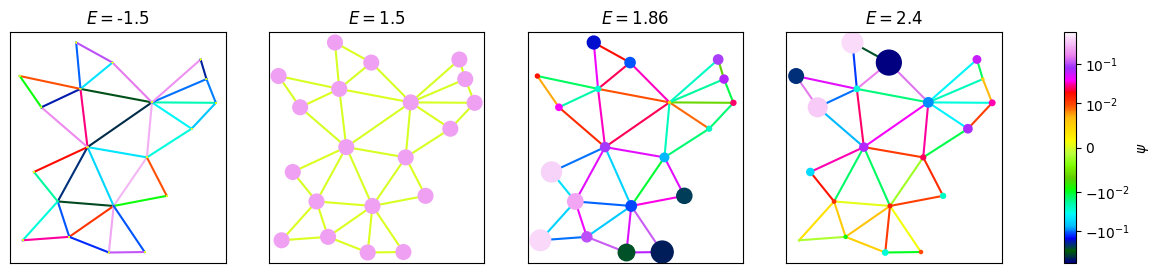

In [9]:
alpha_1 = 0.3
alpha_2 = 0.3
m = 1.5
positions = [20, 37,40, 48]
#Different eigenvectors (not noisy)

four_signals = np.array([generate_signals_eigenvalues_FF(D + m * Gammaf, Nf, Lf, alpha_1, alpha_2, position)[1] for position in positions])
four_lambdas = np.array([generate_signals_eigenvalues_FF(D + m * Gammaf, Nf, Lf, alpha_1, alpha_2, position)[0] for position in positions])

norm = SymLogNorm(linthresh=0.01,
    vmin= -np.max(np.abs(four_signals)), 
    vmax=np.max(np.abs(four_signals)),
    base=10
)


colormap = plt.cm.gist_ncar
color_maps = [[colormap(norm(value)) for value in signal] for signal in four_signals]


Titles = [r"$E = $" + str(round(l,2)) for l in four_lambdas]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
                    
    
for i, ax in enumerate(axes.flat):
    for j in range(len(edge_list_f)):
        edge = edge_list_f[j]
        x1 = posf[edge[0]][0]
        x2 = posf[edge[0]][1]
        y1 = posf[edge[1]][0]
        y2 = posf[edge[1]][1]
        ax.plot([x1,y1], [x2,y2], color = color_maps[i][Nf + j], zorder = 1)
    
    ax.scatter(df_coordinates_f['x'], df_coordinates_f['y'], s = np.abs(four_signals[i][:Nf]) * 500, c = color_maps[i][:Nf], zorder = 2)
    ax.set_title(Titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label=r"$\psi$", ax=axes)
plt.show()

# Behaviour of DSP and DESP (Figure 2)

In [7]:
#Panel (a),(b)
def DSP_plot(D, psi_tilde, psi_true, tau = 10, sigma = 1/2, delta = 1e-4, T = 20):
    """
    Input:
    D: Dirac Operator
    psi_tilde: Noisy signal
    tau: Regularisation parameter
    sigma: Initial step size
    delta: Tolerance on convergence
    T: Minimum iterations
    
    
    Output:
    E_list: List of Es over iterations.
    Error_list: List of Errors over iterations.
    
    """
    
    def func(D,psi_hat,psi_tilde,tau,E): #Evaluation of the function 
        I = np.identity(len(D))
        Norm = np.linalg.norm(psi_hat - psi_tilde,2)**2
        f = Norm + tau * psi_hat.transpose().dot(matrix_power(D - E * I,2).dot(psi_hat))
        return f

    psi_hat = psi_tilde
    psi_second_to_last = np.zeros(len(psi_tilde))
    E = (psi_hat.transpose().dot((D).dot(psi_hat)))/(np.linalg.norm(psi_hat,2)**2)
    I = np.identity(len(D))
    E_list = []
    Error_list = []
    while True:
        A = D - E * I
        psi_hat_new = (np.linalg.inv(I + tau * np.conjugate(A).dot(A))).dot(psi_tilde)
        E_new = (1-sigma) * E + sigma * (psi_hat.transpose().dot((D).dot(psi_hat)))/(np.linalg.norm(psi_hat,2)**2)
        E_exp = psi_hat_new.T.dot(D).dot(psi_hat_new) / (np.linalg.norm(psi_hat_new, 2 ) ** 2)
        #Armijo rule of choosing step size to guarantee convergence.
        if func(D,psi_hat_new,psi_tilde,tau,E) > func(D,psi_hat,psi_tilde,tau,E): 
            sigma /= 2 
            
        else:
            psi_hat = psi_hat_new
            E = E_new
            T -= 1
            E_list.append(E)
            Error_list.append(np.linalg.norm(psi_hat - psi_true, 2))
        if T < 0 and (abs(E_exp - E) < delta or sigma < delta): #If converges
            break
    return E_list, Error_list

<Figure size 640x200 with 0 Axes>

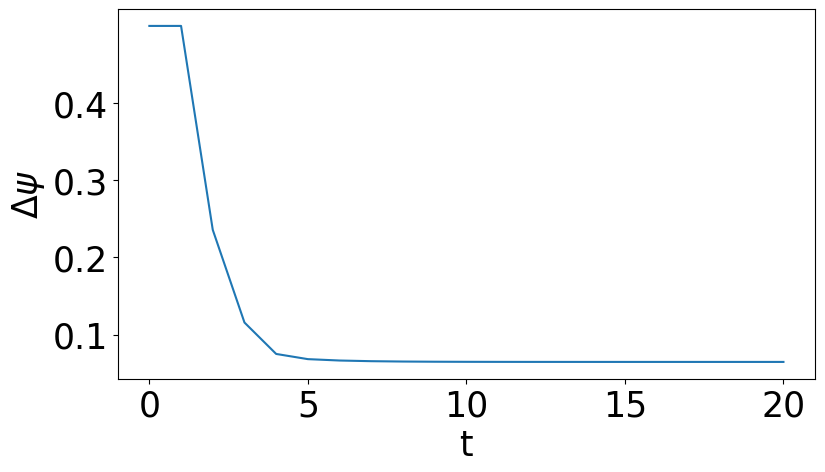

<Figure size 640x200 with 0 Axes>

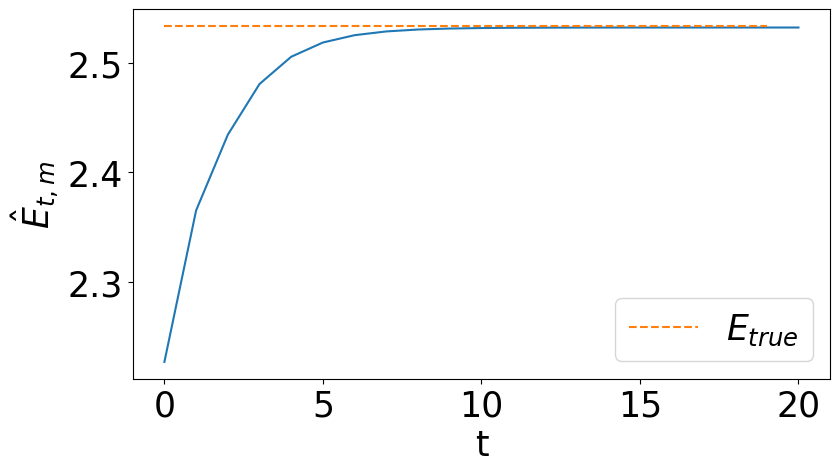

In [19]:
Lambda, psi_true, psi_tilde = generate_signals_eigenvalues_F(D, 0.3, -4)
E_list, Error_list = DSP_plot(D, psi_tilde, psi_true, tau = 10)
matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(Error_list)
plt.xlabel("t")
plt.ylabel(r"$\Delta \psi$")
plt.yticks([0.1, 0.2, 0.3, 0.4]) #Casewise
plt.show()

matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(E_list)
plt.plot(Lambda * np.ones(20), "--", label = "$E_{true}$")

plt.ylabel(r"$\hat{E}_{t,m}$")
plt.xlabel("t")
plt.legend()
plt.show()

In [37]:
#Panel (c),(d)

m0 = 1.5
Lambda, psi_true, psi_tilde = generate_signals_eigenvalues_F(D + m0 * Gammaf, 0.3, 2)
Y1 = []
Y2 = []
m_list = np.linspace(1,2,100)
for m in m_list:
    E, psi_hat = signal_predection_Dirac(D + m * Gammaf, psi_tilde, tau = 10, sigma = 1/2, delta = 1e-4, T = 10)
    Y1.append(np.linalg.norm(psi_true - psi_hat ,2))
    Y2.append(E)

<Figure size 640x200 with 0 Axes>

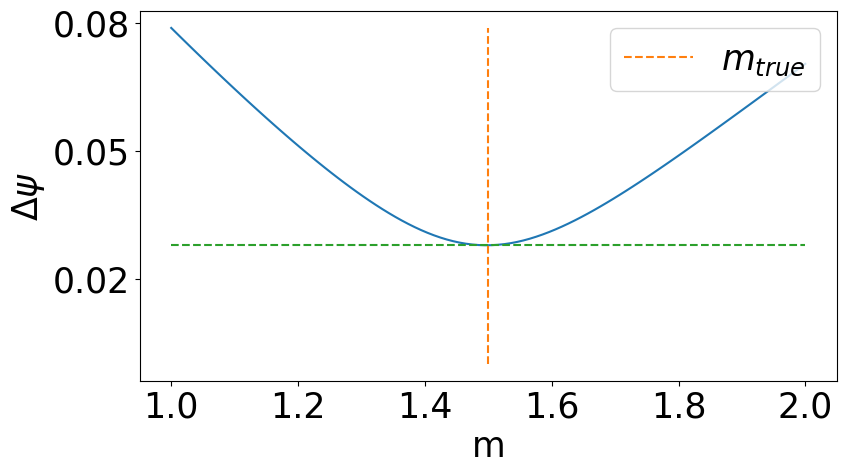

<Figure size 640x200 with 0 Axes>

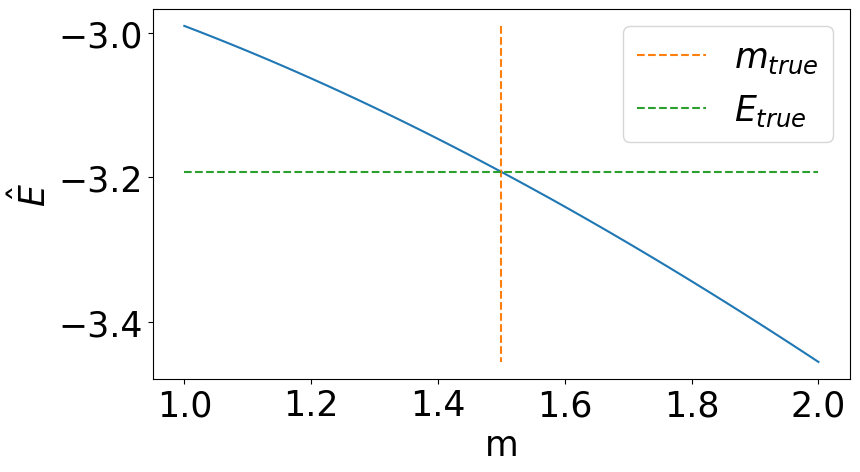

In [27]:
matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list,Y1)
plt.plot(m0 * np.ones(20), np.linspace(0,max(Y1),20), "--", label = r"$m_{true}$")
plt.plot(m_list, min(Y1) * np.ones(100), "--")
plt.ylabel(r"$\Delta \psi$")
plt.xlabel("m")
#plt.ylim(0.05, 0.1)
plt.yticks([0.02, 0.05, 0.08])#Casewise
plt.legend(loc = "upper right")
plt.show()

matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list,Y2)
plt.plot(m0 * np.ones(20), np.linspace(max(Y2),min(Y2),20), "--", label = r"$m_{true}$")
plt.plot(m_list, Lambda * np.ones(100), "--", label = "$E_{true}$")
plt.ylabel(r"$\hat{E}$")
plt.xlabel("m")
plt.legend()
plt.show()

# Minimizing Loss and relativistic dispersion relation error (Figure 3)

In [44]:
m0 = 1.5
Lambda, psi_true, psi_tilde = generate_signals_eigenvalues_F(D + m0 * Gammaf, 0.3, 1)
True_error_f, Loss_f, Dispersion_f, m_list_f = compare_error(D, psi_true, psi_tilde, Gammaf, 0, 3)

<Figure size 640x200 with 0 Axes>

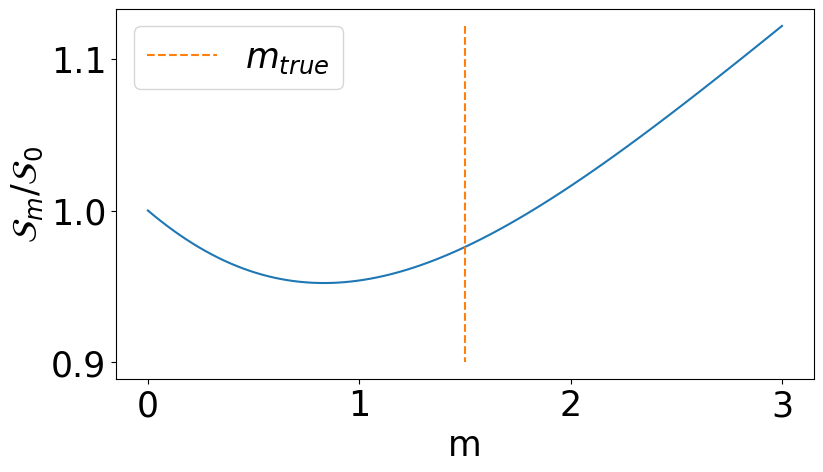

<Figure size 640x200 with 0 Axes>

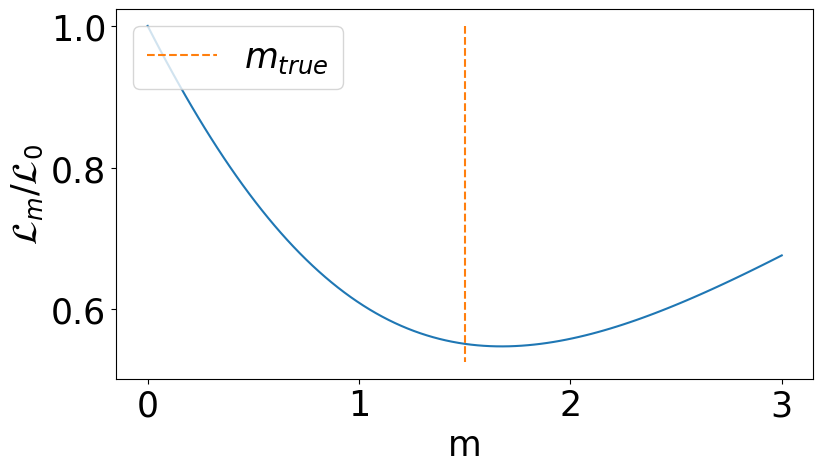

<Figure size 640x200 with 0 Axes>

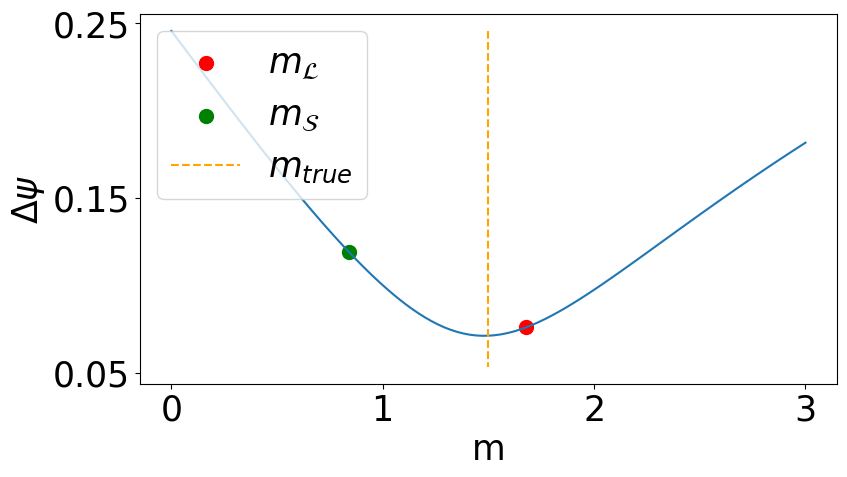

In [47]:
matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list_f, np.array(Dispersion_f)/Dispersion_f[0])
plt.plot(m0 * np.ones(len(m_list_f)), np.linspace( max(Dispersion_f)/Dispersion_f[0], 0.9 ,len(m_list_f)), "--", label = r"$m_{true}$")
plt.ylabel(r"$\mathcal{S}_m/\mathcal{S}_0$")
plt.yticks([0.9,1.0,1.1])
plt.xlabel("m")
plt.legend(loc = "upper left")
plt.show()


matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list_f, np.array(Loss_f)/Loss_f[0])
plt.plot(m0 * np.ones(len(m_list_f)), np.linspace(max(Loss_f)/Loss_f[0], min(Loss_f)/Loss_f[0] * 0.96,len(m_list_f)), "--", label = r"$m_{true}$")
plt.ylabel(r"$\mathcal{L}_m/\mathcal{L}_0$")
plt.yticks([0.6,0.8,1.0])
plt.xlabel("m")
plt.legend(loc = "upper left")
plt.show()

matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(2)
plt.figure().set_figwidth(9)
plt.plot(m_list_f, np.array(True_error_f))
plt.scatter(m_list_f[np.argmin(Loss_f)], True_error_f[np.argmin(Loss_f)], s = 100, color = "red", label = r"$m_\mathcal{L}$")
plt.scatter(m_list_f[np.argmin(Dispersion_f)], True_error_f[np.argmin(Dispersion_f)], color = "green" , s = 100, label = r"$m_\mathcal{S}$")
plt.plot(m0 * np.ones(len(m_list_f)), np.linspace(max(True_error_f),min(True_error_f) * 0.75,len(m_list_f)), "--", label = r"$m_{true}$", color = "orange")

plt.xticks([0,1,2,3])
plt.yticks([0.05, 0.15, 0.25])
plt.xlabel("m")
plt.ylabel(r"$\Delta \psi$")
plt.legend(loc="upper left")
plt.show()

# DSP is important while DESP and handle a wider range of signals (Figure 4)

In [62]:
def compare_L_D(D, tau = 10, sigma = 1/8, delta = 1e-4, T = 10 , n = 31, alpha = 0.3):
    
    
    """
    Input:
    D: Dirac Operator
    tau: Regularisation parameter
    sigma: Initial step size
    delta: Tolerance on convergence
    T: Minimum iteration
    n: Number of sampled m
    alpha: Noise size
    
    
    Output:
    DSP_MEAN,DSP_std: Mean, standard deviation result using DSP.
    LSP_MEAN,LSP_std: Mean, standard deviation result using LSP.
    m_list: List of m.
    
    
    """
    

    E_list = []
    DSP_MEAN = []
    DSP_std = []
    LSP_MEAN = []
    LSP_std = []
    

    E_list = np.linalg.eigh(D)[0] 
    
    
    #For each E in the E_list, we tested the randomly generated 100 signals. 
    for j in range(len(E_list)):
        dsp_error_pos = []
        lsp_error_pos = []
        
        for i in range(100):
                Lambda, psi_true, psi_tilde = generate_signals_eigenvalues_F(D, alpha,j)
                psi_hat_d = signal_predection_Dirac(D, psi_tilde, tau, sigma, delta, T)[1]
                psi_hat_l = signal_predection_Laplacian(D, psi_tilde, tau)
                dsp_error_pos.append(np.linalg.norm(psi_hat_d - psi_true,2))
                lsp_error_pos.append(np.linalg.norm(psi_hat_l - psi_true,2))
        
        dsp_error_pos.sort()
        lsp_error_pos.sort()
        DSP_MEAN.append(np.mean(dsp_error_pos))
        LSP_MEAN.append(np.mean(lsp_error_pos))
        DSP_std.append(np.std(dsp_error_pos))
        LSP_std.append(np.std(lsp_error_pos))
    return np.array(DSP_MEAN),np.array(DSP_std),np.array(LSP_MEAN),np.array(LSP_std), E_list


def compare_D_DE(D, Gamma, tau = 10, sigma = 1/8, delta = 1e-4, T = 10 , n = 20, alpha = 0.3):
    
    
    """
    Input:
    D: Dirac Operator
    Gamma: Gamma matrix
    tau: Regularisation parameter
    sigma: Initial step size
    delta: Tolerance on convergence
    T: Minimum iteration
    n: Number of sampled m
    alpha: Noise size
    
    
    Output:
    DSP_MEAN,DSP_std,DSP_std: Mean, standard deviation result using DSP.  80% confidence interval.
    DESP_MEAN,DESP_std: Mean, standard deviation result using DESP.  80% confidence interval.
    m_list: List of m.
    
    
    """
    
    
    m_list = np.linspace(-2,2,n)
    
    DSP_MEAN = []
    DSP_std = []
    DESP_MEAN = []
    DESP_std = []
    
    #Record the indices of non-harmonic eigenvectors.
    indices = []
    Lambdas = np.linalg.eigh(D)[0] 
    for i in range(len(Lambdas)):
        if abs(Lambdas[i]) > 1e-4:
            indices.append(i)
    positions = np.random.choice(indices,50) # random 50 positions of eigenvectors.
    
    #For each m in the m_list, we tested the randomly generated 50 signals. 
    for m in m_list:
        dsp_error_pos = []
        desp_error_pos = []
        
        for position in positions:
                Lambda, psi_true, psi_tilde = generate_signals_eigenvalues_F(D + m * Gamma, alpha, position)
                psi_hat_d = signal_predection_Dirac(D, psi_tilde, tau, sigma, delta, T)[1]
                psi_hat_de = signal_predection_Dirac_Equation(D, psi_tilde, Gamma)[2]
                dsp_error_pos.append(np.linalg.norm(psi_hat_d - psi_true,2))
                desp_error_pos.append(np.linalg.norm(psi_hat_de - psi_true,2))
                
        dsp_error_pos.sort()
        desp_error_pos.sort()
        DSP_MEAN.append(np.average(dsp_error_pos))
        DESP_MEAN.append(np.mean(desp_error_pos))
        DSP_std.append(np.std(dsp_error_pos))
        DESP_std.append(np.std(desp_error_pos))
    return np.array(DSP_MEAN),np.array(DSP_std),np.array(DESP_MEAN),np.array(DESP_std), m_list

In [63]:
DSP_MEAN,DSP_std,LSP_MEAN,LSP_std, E_list = compare_L_D(D, tau = 10)

<Figure size 640x400 with 0 Axes>

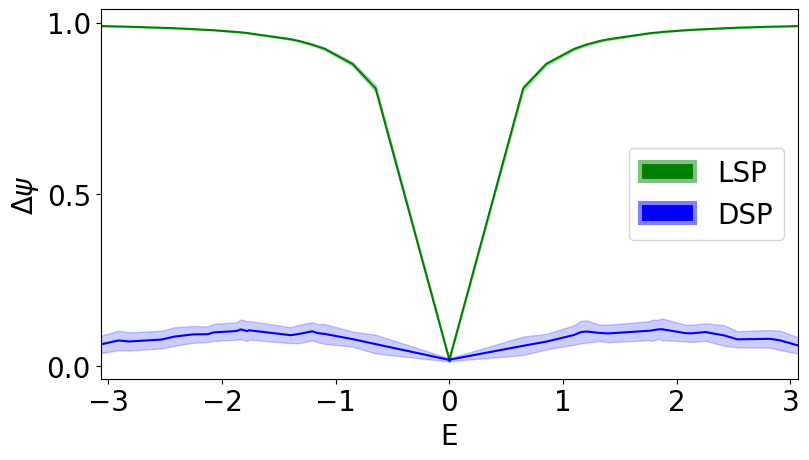

In [64]:
E_list = np.linalg.eigh(D1f)[0] 
matplotlib.rcParams.update({'font.size': 20})
bg = np.array([1, 1, 1])
colors = ['green', 'blue']
colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
plt.figure().set_figheight(4)
plt.figure().set_figwidth(9)
plot_mean_and_CI(E_list, LSP_MEAN, LSP_MEAN - LSP_std, LSP_MEAN + LSP_std, color_mean='g', color_shading='g')
plot_mean_and_CI(E_list, DSP_MEAN, DSP_MEAN - DSP_std, DSP_MEAN + DSP_std, color_mean='b', color_shading='b')
plt.xlabel("E")
plt.ylabel(r"$\Delta \psi$")
plt.legend([0, 1], ["LSP","DSP"],
           handler_map={
               0: LegendObject(colors[0], colors_faded[0]),
               1: LegendObject(colors[1], colors_faded[1])
            }, loc = "right")
plt.yticks([0.0,0.5,1.0])
plt.xlim(min(E_list), max(E_list))
plt.show()

In [65]:
DSP_MEAN_2,DSP_std_2,DESP_MEAN,DESP_std, m_list = compare_D_DE(D, Gammaf)

<Figure size 640x400 with 0 Axes>

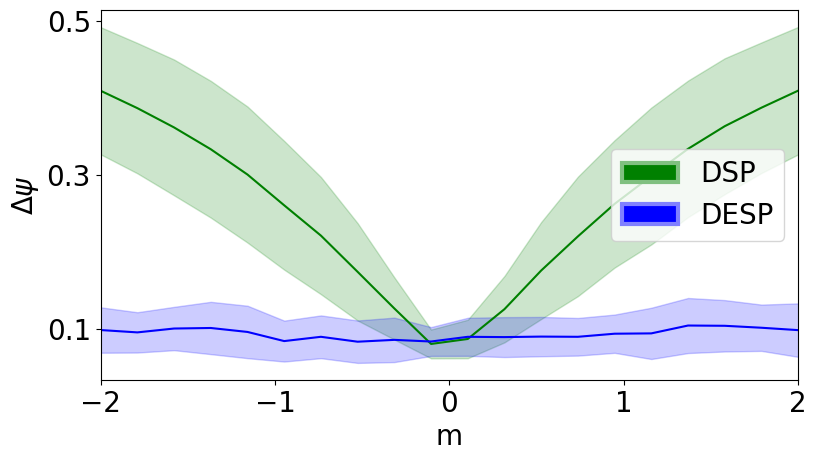

In [67]:
matplotlib.rcParams.update({'font.size': 20})
bg = np.array([1, 1, 1])
colors = ['green', 'blue']
colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
plt.figure().set_figheight(4)
plt.figure().set_figwidth(9)
plot_mean_and_CI(m_list, DSP_MEAN_2, DSP_MEAN_2 - DSP_std_2, DSP_MEAN_2 + DSP_std_2, color_mean='g', color_shading='g')
plot_mean_and_CI(m_list, DESP_MEAN, DESP_MEAN - DESP_std, DESP_MEAN + DESP_std, color_mean='b', color_shading='b')
plt.xlabel("m")
plt.ylabel(r"$\Delta \psi$")
plt.legend([0, 1], ["DSP","DESP"],
           handler_map={
               0: LegendObject(colors[0], colors_faded[0]),
               1: LegendObject(colors[1], colors_faded[1])
            }, loc="right")
plt.xlim(-2,2)
plt.yticks([0.1,0.3,0.5])
plt.xticks([-2,-1,0,1,2])
plt.show()

# Different error scales on nodes and links (Figure 5)

In [71]:
def different_error_scale(D, N, alpha_fix, position, fix_on_what):
    
    """
    Input:
    D: Dirac Operator.
    N: Number of nodes, 20 in this case.
    alpha_fix: Fixed alpha.
    position: Index of eigenstate.
    fix_on_what: Fixed alpha on node or links.
    
    
    Output:
    Over_node: List of node errors.
    Over_edge: List of edge errors.
    alpha_vary: List of alphas
    
    """
    alpha_vary = np.linspace(0,alpha_fix,10)
    Over_node = []
    Over_edge = []
    
    for alpha in alpha_vary:
        Temp_node = []
        Temp_edge = []
        for t in range(200):
            if fix_on_what == "node":
                psi_true_temp, psi_tilde_temp = generate_signals_eigenvalues_FF(D, N, Lf, alpha_fix, alpha, position)[1:]
            else:
                psi_true_temp, psi_tilde_temp = generate_signals_eigenvalues_FF(D, N, Lf, alpha, alpha_fix, position)[1:]
            psi_hat_temp = signal_predection_Dirac_Equation(D, psi_tilde_temp, Gammaf)[2]
            Temp_node.append(np.linalg.norm(psi_hat_temp[:N] - psi_true_temp[:N],2)/np.linalg.norm(psi_true_temp[:N],2))
            Temp_edge.append(np.linalg.norm(psi_hat_temp[N:] - psi_true_temp[N:],2)/np.linalg.norm(psi_true_temp[N:],2))
        Over_node.append([np.average(Temp_node), np.std(Temp_node)])
        Over_edge.append([np.average(Temp_edge), np.std(Temp_edge)])
        
    return np.array(Over_node), np.array(Over_edge), alpha_vary

In [72]:
#Fixed on node
Node_1, Link_1, alpha_vary = different_error_scale(D + 1.5 * Gammaf, Nf, 0.5, 3, "node")
#Fixed on link
Node_2, Link_2, alpha_vary = different_error_scale(D + 1.5 * Gammaf, Nf, 0.5, 3, "link")

<Figure size 640x400 with 0 Axes>

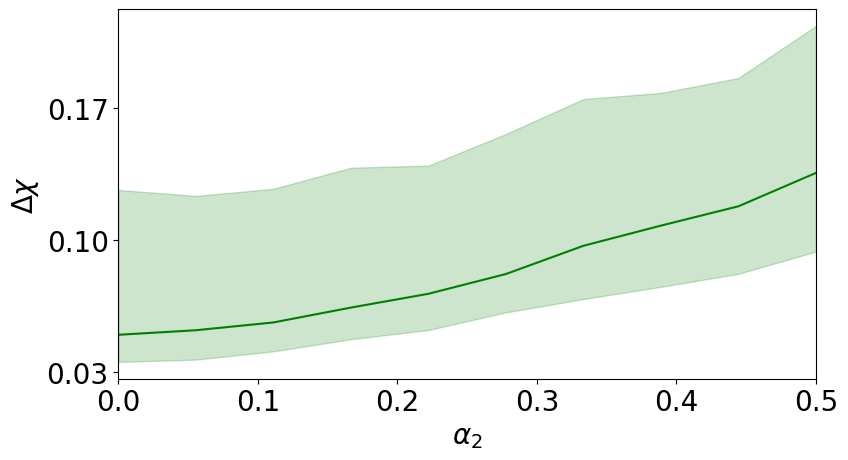

<Figure size 640x400 with 0 Axes>

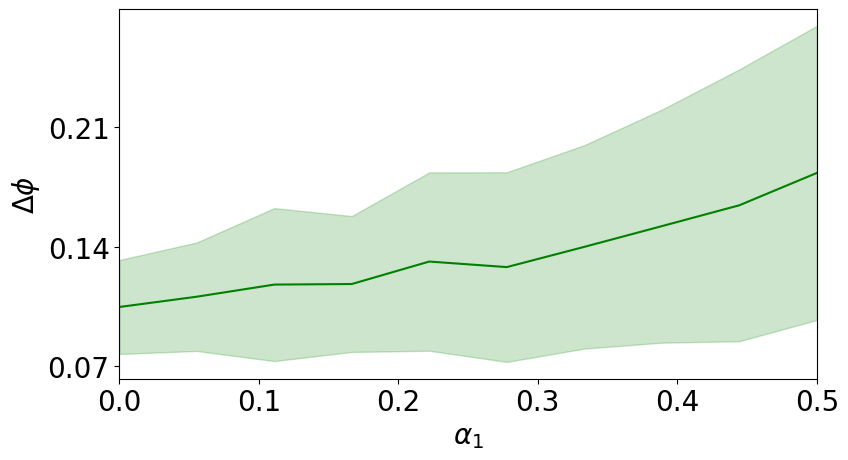

In [73]:
matplotlib.rcParams.update({'font.size': 20})
bg = np.array([1, 1, 1])
colors = ['green', 'blue']
colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
plt.figure().set_figheight(4)
plt.figure().set_figwidth(9)
plot_mean_and_CI(alpha_vary, Link_1[:,0], Link_1[:,0] - Link_1[:,1], Link_1[:,0] + Node_1[:,1], color_mean='g', color_shading='g')
plt.xlabel(r"$\alpha_2$")
plt.ylabel(r"$\Delta \chi$")
plt.xlim(0,0.5)
#plt.yticks([0.0,0.1,0.2])
plt.yticks([0.03, 0.1, 0.17])
plt.show()

matplotlib.rcParams.update({'font.size': 20})
bg = np.array([1, 1, 1])
colors = ['green', 'blue']
colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]
plt.figure().set_figheight(4)
plt.figure().set_figwidth(9)
plot_mean_and_CI(alpha_vary, Node_2[:,0], Node_2[:,0] - Node_2[:,1], Node_2[:,0] + Node_2[:,1], color_mean='g', color_shading='g')
plt.xlabel(r"$\alpha_1$")
plt.ylabel(r"$\Delta \phi$")
plt.yticks([0.07, 0.14, 0.21])
plt.xlim(0,0.5)
plt.show()